#  요구사항 1. titanic_dataset.py 분석

In [1]:
import os
import pandas as pd
import torch 
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

### DATASET class

In [2]:
class TitanicDataset(Dataset): # 훈련용 데이터 셋
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X) # 피처를 float 텐서로 초기화
    self.y = torch.LongTensor(y)  # 레이블을 long 텐서로 초기화

  def __len__(self):
    return len(self.X)            # 피처 텐서의 길이를 출력 (피처의 개수)

  def __getitem__(self, idx):
    feature = self.X[idx]         # idx번째 피처의 값과 레이블을 넣는다. 
    target = self.y[idx]          # --> 지도학습
    return {'input': feature, 'target': target}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape # 피처 텐서의 길이와 shape, 레이블 텐서의 shape를 출력한다.
    )
    return str

In [3]:
class TitanicTestDataset(Dataset): # 평가용(테스트용) 데이터 셋
  def __init__(self, X):
    self.X = torch.FloatTensor(X)  # testDataset이므로 레이블은 주어지지 않는다. 따라서 피처만 초기화한다.

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    return {'input': feature}   # 피처만 알고 있으므로 피처 입력값 출력

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}".format(
      len(self.X), self.X.shape  # 피처의 길이와 shape 출력
    )
    return str

### DATA preprocessing

In [4]:
def get_preprocessed_dataset():  # 데이터셋 전처리 과정
    CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__")) # 현재 디렉토리 경로 가져오기
    # 이와 같이 하면 코드를 돌리는 파일.py or .ipynb가 csv 파일과 같은 폴더 내에 있으면 
    # 코드 실행시 경로를 직접 얻어와 파일 사용이 가능하다.
    train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv") # train.csv 파일 경로
    test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")   # test.csv 파일 경로

    train_df = pd.read_csv(train_data_path) # pandas를 이용해 csv 파일을 불러온다.
    test_df = pd.read_csv(test_data_path)

    all_df = pd.concat([train_df, test_df], sort=False) # train데이터와 test 데이터를 concat으로 합친다. (전처리를 한번에 하기 위해)
    
    # Pclass별 Fare 평균값을 사용하여 Fare 결측치 메우기
    all_df = get_preprocessed_dataset_1(all_df) 
    
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    all_df = get_preprocessed_dataset_2(all_df)

    # honorific별 Age 평균값을 사용하여 Age 결측치 메우기
    all_df = get_preprocessed_dataset_3(all_df)

    # 가족수(family_num) 컬럼 새롭게 추가
    all_df = get_preprocessed_dataset_4(all_df)

    # honorific 값 개수 줄이기
    all_df = get_preprocessed_dataset_5(all_df)

    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    all_df = get_preprocessed_dataset_6(all_df)

    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True) # 데이터프레임에서 레이블인 "Survived" 열 제거해서 훈련 데이터셋의 입력 데이터를 만든다.
    train_y = train_df["Survived"] # "Survived" 열만 선택: 레이블

    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True) # 마찬가지로 레이블을 제거해서 테스트용 입력 데이터를 만든다.

    dataset = TitanicDataset(train_X.values, train_y.values) # 훈련 데이터 셋을 만든다.
    #print(dataset)
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2]) # 훈련 데이터 셋을 무작위로 8:2로 나눠 훈련용 데이터 셋과 검증용 데이터 셋으로 나눈다.
    test_dataset = TitanicTestDataset(test_X.values) # 테스트용 데이터 셋을 만든다.
    #print(test_dataset)

    return train_dataset, validation_dataset, test_dataset

In [5]:
# 입력값들 중에 값이 없는 경우가 있다. 이때 아무 값도 넣지 않은 상태로 하면 0으로 처리가 된다.
# 그러나 만약 이 입력값들이 큰 값을 가질 경우 missing value는 평균에 큰 영향을 줄 수 있으므로, 
# missing value를 입력값들의 평균으로 메운다.
def get_preprocessed_dataset_1(all_df):
    # Pclass별 Fare 평균값을 사용하여 Fare 결측치 메우기
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    # all_df[["Pclass", "Fare"]]  --> 데이터 프레임에서 "Pclass", "Fare" 열만 선택
    # .groupby("Pclass") --> 데이터프레임을 "Pclass" 열을 기준으로 그룹화
    # .mean() --> 각각의 "Pclass" 그룹에 대해 "Fare"의 평균값을 구한다.
    # .reset_index() --> 그룹화된 결과를 다시 인덱스를 리셋하여 새로운 데이터프레임으로 만든다.
    
    Fare_mean.columns = ["Pclass", "Fare_mean"] 
    # 새롭게 만들어진 데이터 프레임에 열 이름을 지정한다.
    
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left") 
    # 두 데이터 프레임(all_df, Fare_mean)을 합친다.
    # on="Pclass" --> 두 데이터프레임을 합칠 때 기준이 되는 열
    # how="left" --> 왼쪽 데이터프레임(all_df)을 기준으로 합친다. all_df의 모든 행을 유지하면서, Fare_mean이라는 열을 추가한다. 
    
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"] # 결측치 메우기
    # all_df["Fare"].isnull() --> Fare 열에 대해 각 행에 대한 결측치 판단 (True, False)
    # all_df.loc[(all_df["Fare"].isnull()), "Fare"] --> 결측치를 가진 Fare 열의 값
    # all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]
    # --> 결측치를 가진 Fare 열의 각각에 Fare_mean의 열의 값을 넣는다. (결측치를 메운다.)
    return all_df

In [6]:
def get_preprocessed_dataset_2(all_df):
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True) 
    # 정규표현식 [,.]을 기준으로 문자열을 최대 2번 분리. expand=True --> 분리된 문자열을 데이터 프레임으로 반환
    # 즉 name_df는 name 열이 세 열로 나뉜 결과가 저장된다. 
    
    name_df.columns = ["family_name", "honorific", "name"]  # 성, 경칭, 이름으로 열 이름을 붙인다.
    
    # 각 열의 값에 대해 앞뒤 공백을 제거 (불필요한 공백)
    name_df["family_name"] = name_df["family_name"].str.strip() 
    name_df["honorific"] = name_df["honorific"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    
    all_df = pd.concat([all_df, name_df], axis=1)
    # all_df와 name_df를 열방향(axis = 1)로 합친다. 
    # --> "family_name", "honorific", "name" 열이 all_df에 추가

    return all_df

In [7]:
def get_preprocessed_dataset_3(all_df):
    # honorific별 Age 평균값을 사용하여 Age 결측치 메우기
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()
    # all_df에서 "honorific"과 "Age"만 선택한 후, "honorific"열을 기준으로 그룹화한다. 
    # .median() --> 각 그룹 내의 "Age" 값들의 중앙값을 계산
    # .round() --> 계산된 중앙값을 반올림
    # honorific_age_mean 이라는 새로운 데이터 프레임 생성
    
    honorific_age_mean.columns = ["honorific", "honorific_age_mean", ]
    # honorific_age_mean 데이터 프레임의 열에 이름을 붙인다. 
    
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
    # "honorific"열을 기준으로, all_df와 honorific_age_mean 데이터 프레임을 합친다. 
    
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]
    # all_df의 "Age"열의 결측치를 all_df["honorific_age_mean"]의 값으로 메운다.
    
    all_df = all_df.drop(["honorific_age_mean"], axis=1)
    # all_df에서 열 "honorific_age_mean"을 없앤다.

    return all_df

In [8]:
def get_preprocessed_dataset_4(all_df):
    # 가족수(family_num) 컬럼 새롭게 추가
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]
    # Parch: 부모/자녀 수
    # SibSp: 형제/배우자 수

    # 혼자탑승(alone) 컬럼 새롭게 추가
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"].fillna(0, inplace=True)
    # 가족수가 0인 경우(all_df["family_num"] == 0) 혼자 탑승 all_df["alone"]=1

    # 학습에 불필요한 컬럼 제거
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    return all_df

In [9]:
def get_preprocessed_dataset_5(all_df):
    # honorific 값 개수 줄이기
    all_df.loc[
    ~(
            (all_df["honorific"] == "Mr") |
            (all_df["honorific"] == "Miss") |
            (all_df["honorific"] == "Mrs") |
            (all_df["honorific"] == "Master")
    ),  # "honorific"의 값이 위의 경우에 해당되지 않는 경우
    "honorific"
    ] = "other" # 나머지는 전부 "other"값으로 대체된다.
    
    all_df["Embarked"].fillna("missing", inplace=True)
    # "Embarked" 열에서 결측치를 "missing"으로 채운다.

    return all_df

In [10]:
def get_preprocessed_dataset_6(all_df):
    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    category_features = all_df.columns[all_df.dtypes == "object"]
    # all_df에서 데이터타입이 obgect인 열들을 선택해서 category_features에 저장
    
    from sklearn.preprocessing import LabelEncoder
    for category_feature in category_features: # 모든 category_features의 열에 대해
        le = LabelEncoder() # LabelEncoder 객체 생성
        if all_df[category_feature].dtypes == "object": # 현재 처리 중인 열의 데이터 타입이 "object"인 경우
          le = le.fit(all_df[category_feature]) # 각 카테고리를 고유한 정수로 매핑
          all_df[category_feature] = le.transform(all_df[category_feature])
          # LabelEncoder를 사용하여 해당 열의 값들을 정수로 변환

    return all_df

### Model

In [11]:
from torch import nn
class MyModel(nn.Module): # nn.Module을 상속바다 MyModel 클래스 정의
  def __init__(self, n_input, n_output):
    super().__init__()
    
    # nn.Sequential을 사용해 모델 구조를 정의한다.
    self.model = nn.Sequential(
      nn.Linear(n_input, 30), # 입력 레이어, 30개의 뉴런
      nn.ReLU(), # 활성화 함수
      nn.Linear(30, 30), # 30개의 뉴런에서 30개의 뉴런으로 연결되는 레이어
      nn.ReLU(), # 활성화 함수
      nn.Linear(30, n_output), # 30개의 뉴런에서 출력으로 이어지는 레이어
    )
    # ReLU -> output = [0, INF)
    # ReLU는 입력값이 음수면 0, 양수면 그 값을 그대로 반환

  def forward(self, x): # 객체를 생성할때 기본적으로 사용됨
    x = self.model(x) # 입력 x를 모델을 통과
    return x # 출력반환

In [12]:
def test(test_data_loader):
  id = []
  survived = []
  print("[TEST]")
  batch = next(iter(test_data_loader)) # 테스트 데이터 로더에서 배치를 하나 가져온다.
  print("{0}".format(batch['input'].shape)) # 가져온 배치 출력
  my_model = MyModel(n_input=11, n_output=2) # 모델 초기화, output=2는 생존 1 사망 0이다.
  output_batch = my_model(batch['input']) # 배치를 모델에 전달하여 출력을 얻음
  prediction_batch = torch.argmax(output_batch, dim=1) # 출력에서 각 샘플의 예측값을 찾는다. 
  # 한 샘플의 예측값이 [0.2, 0.8] 일때, argmax는 두 값중 큰 값의 인덱스를 반환한다.
  # 따라서 위 샘플에서는 1을 반환하며, 생존을 예측하였다.
  # dim=1은, 입력 값이 배치로 이므로, 배치의 각 샘플에 접근하기 위함이다. 
  for idx, prediction in enumerate(prediction_batch, start=892):
      print(idx, prediction.item()) # 예측된 값을 출력한다.
      id.append(idx) # 추가
      survived.append(prediction.item()) #추가
  return id, survived

In [13]:
if __name__ == "__main__":
    
  # 데이터 전처리 후, 훈련 데이터 셋과, 검증데이터 셋, 테스트 데이터 셋으로 분할한다.
  train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()
  
  # 분할한 데이터들을 출력해보기
  print("train_dataset: {0}, validation_dataset.shape: {1}, test_dataset: {2}".format(
    len(train_dataset), len(validation_dataset), len(test_dataset)
  ))
  print("#" * 50, 1)
  
  # 훈련 데이터 셋 입력값과 타겟값 출력해보기
  for idx, sample in enumerate(train_dataset):
    print("{0} - {1}: {2}".format(idx, sample['input'], sample['target']))

  print("#" * 50, 2)
  # 받아온 데이터 셋을 데이터 로더로 변환
  train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
  validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=16, shuffle=True) # 배치 사이즈는 16이다.
  test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))
  # 테스트 데이터셋을 한 번에 로드. 배치 사이즈는 테스트 데이터셋의 전체 길이이다. 
  
  #  데이터 로더의 값 출력
  print("[TRAIN]")
  for idx, batch in enumerate(train_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("[VALIDATION]")
  for idx, batch in enumerate(validation_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("#" * 50, 3)
  
  # 훈련코드 없음
  
  # 모델 테스트 
  idx, survived = test(test_data_loader) # 수정


train_dataset: 713, validation_dataset.shape: 178, test_dataset: 418
################################################## 1
0 - tensor([ 1.0000,  1.0000, 29.0000,  1.0000,  0.0000, 66.6000,  2.0000, 87.5090,
         2.0000,  1.0000,  0.0000]): 0
1 - tensor([ 3.0000,  1.0000, 29.0000,  0.0000,  0.0000, 14.4583,  0.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
2 - tensor([ 3.0000,  1.0000, 24.0000,  0.0000,  0.0000,  7.8958,  2.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
3 - tensor([ 2.0000,  0.0000, 28.0000,  0.0000,  0.0000, 12.6500,  2.0000, 21.1792,
         3.0000,  0.0000,  1.0000]): 1
4 - tensor([ 3.0000,  1.0000, 29.0000,  0.0000,  0.0000,  7.7500,  1.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 1
5 - tensor([ 1.0000,  1.0000, 56.0000,  0.0000,  0.0000, 30.6958,  0.0000, 87.5090,
         2.0000,  0.0000,  1.0000]): 0
6 - tensor([ 3.0000,  1.0000, 65.0000,  0.0000,  0.0000,  7.7500,  1.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
7 - tensor([ 3.00

# 요구사항 2. titanic 딥러닝 모델 훈련 코드 및 Activation Function 변경해보기

In [15]:
from datetime import datetime
import wandb
import argparse

from pathlib import Path
BASE_PATH = str(Path("__file__").resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl

import sys
sys.path.append(BASE_PATH)

In [44]:
class MyModel(nn.Module):
  def __init__(self, n_input, n_output):
    super().__init__()

    self.model = nn.Sequential(
      nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),
      #nn.ELU(),
      #nn.LeakyReLU(0.2),
      nn.PReLU(),
      nn.Dropout(0.2), # overfitting 방지
      nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
      #nn.ELU(),
      #nn.LeakyReLU(0.2),
      nn.PReLU(),
      nn.Dropout(0.2),
      nn.Linear(wandb.config.n_hidden_unit_list[1], n_output),
      nn.Sigmoid()  # 여기에 시그모이드 함수 추가
    )

  def forward(self, x):
    x = self.model(x)
    return x

In [39]:
def get_model_and_optimizer():
  my_model = MyModel(n_input=11, n_output=2) 
  optimizer = optim.SGD(my_model.parameters(), lr=wandb.config.learning_rate)

  return my_model, optimizer

In [40]:
def training_loop(model, optimizer, train_data_loader, validation_data_loader):
  n_epochs = wandb.config.epochs
  loss_fn = nn.BCELoss()  # 수정
  next_print_epoch = 100
  loss_list = []
  count = 0
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    num_trains = 0
    # 훈련
    for train_batch in train_data_loader:
      input_data = train_batch['input']
      target = train_batch['target'].unsqueeze(1)  # 수정2
      target = torch.cat((1 - target, target), dim=1) # 수정2
      
      output_train = model(input_data) 
      probabilities = torch.sigmoid(output_train) # 수정2
      loss = loss_fn(probabilities, target.float()) # 수정2
      
      #prediction_train = torch.argmax(output_train, dim=1)  # 수정
      #loss = loss_fn(prediction_train.float(), train_batch['target'].float()) # 수정
      
      loss_train += loss.item()
      num_trains += 1

      optimizer.zero_grad()
      loss.requires_grad_(True)
      loss.backward()
      optimizer.step()
        
    # 검증
    loss_validation = 0.0
    num_validations = 0
    with torch.no_grad():
      for validation_batch in validation_data_loader:
        output_validation = model(validation_batch['input'])
        #prediction_valid = torch.argmax(output_validation, dim=1) # 수정
        prediction_valid = torch.sigmoid(output_validation) # 수정2
        
        target_v = validation_batch['target'].unsqueeze(1).float() # 수정2
        target_v = torch.cat((1 - target_v, target_v), dim=1)      # 수정2
        
        loss = loss_fn(prediction_valid.float(),target_v) # 수정 2
        # loss = loss_fn(prediction_valid.float(),validation_batch['target'].float()) # 수정
        
        loss_validation += loss.item()
        num_validations += 1

    wandb.log({
      "Epoch": epoch,
      "Training loss": loss_train / num_trains,
      "Validation loss": loss_validation / num_validations
    })
    
    loss_value = loss_validation / num_validations
    loss_list.append(loss_value)
    if len(loss_list) > 3:
        loss_mean = sum(loss_list)/len(loss_list)
        if loss_mean < loss_value:
            count += 1
    if epoch > 500 and count >50:
        break
    if epoch > 100: loss_list.pop(0)
    if epoch >= next_print_epoch:
      print(count)
      count = 0
      print(
        f"Epoch {epoch}, "
        f"Training loss {loss_train / num_trains:.4f}, "
        f"Validation loss {loss_validation / num_validations:.4f}"
      )
      next_print_epoch += 100

In [41]:
def main(args):
  current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'learning_rate': 1e-5,
    'n_hidden_unit_list': [30, 30],
  }

  wandb.init(
    mode="online" if args.wandb else "disabled",
    project="my_titanic_training",
    notes="My titanic experiment",
    tags=["my_model", "titanic"],
    name=current_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()
  
  train_data_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True)
  validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=args.batch_size, shuffle=True) # 배치 사이즈는 16이다.
  test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))
  
  linear_model, optimizer = get_model_and_optimizer()

  wandb.watch(linear_model)

  print("#" * 50, 1)

  training_loop(
    model=linear_model,
    optimizer=optimizer,
    train_data_loader=train_data_loader,
    validation_data_loader=validation_data_loader
  )
  
  # submission 파일 생성
  idx, survived = test(test_data_loader)
  data = pd.DataFrame({'PassengerId': idx, 'Survived': survived})
  data.to_csv('C:/Users/loien/Desktop/23-2/딥러닝/titanic/submission.csv', index=False)
  wandb.finish()

In [42]:
# https://docs.wandb.ai/guides/track/config
if __name__ == "__main__":

  args = argparse.Namespace(wandb=True, batch_size=16, epochs=5000)
  main(args)

Namespace(wandb=True, batch_size=16, epochs=5000)
{'epochs': 5000, 'batch_size': 16, 'learning_rate': 1e-05, 'n_hidden_unit_list': [30, 30]}
################################################## 1
44
Epoch 100, Training loss 0.7058, Validation loss 0.7082
51
Epoch 200, Training loss 0.7077, Validation loss 0.7246
43
Epoch 300, Training loss 0.7050, Validation loss 0.7096
39
Epoch 400, Training loss 0.7023, Validation loss 0.7013
45
Epoch 500, Training loss 0.7026, Validation loss 0.7073
40
Epoch 600, Training loss 0.7046, Validation loss 0.7100
45
Epoch 700, Training loss 0.6970, Validation loss 0.7112
42
Epoch 800, Training loss 0.6939, Validation loss 0.6990
36
Epoch 900, Training loss 0.6932, Validation loss 0.6929
48
Epoch 1000, Training loss 0.6905, Validation loss 0.6856
41
Epoch 1100, Training loss 0.6889, Validation loss 0.6902
36
Epoch 1200, Training loss 0.6874, Validation loss 0.6937
41
Epoch 1300, Training loss 0.6804, Validation loss 0.7048
40
Epoch 1400, Training loss 0.6824

Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training loss,███▇█▇▆▇▆▆▅▅▅▄▅▄▄▄▃▃▃▃▂▃▃▂▂▂▂▂▂▁▂▂▂▁▂▁▁▂
Validation loss,▇█▇▆▆▆▆█▇▇▆▄▆▇▅▇▃▅▃▅▅▄▃▆▂▃▄▄▃▂▃▅▃▃▃▁▅▁▂▁
Epoch,3098
Training loss,0.6715
Validation loss,0.67863


#### 훈련코드
- 위 training_loop 코드에 주석으로 #수정 과 #수정2 코드는 loss_fn에 넣는 텐서의 차원이 다르다. 
- 수정 은 1차원 텐서로, 예측값이 1인지 0인지를 타겟값과 비교한다.
- 수정2는 2차원 텐서로, 사망(0)일 확률, 생존(1)일 확률을 시그모이드 함수에 넣은 뒤, BCELoss 함수에 넣는다.
- 이때 타겟값의 텐서를 1차원 늘려주고, 인덱스가 0일때는 사망(0)으로, 인덱스가 1일때는 생존(1)이 들어가도록 2차원 텐서로 바꾼다.

- 수정 코드르 사용했을 때, loss값이 너무 크게 나오고, BCE를 사용하기에 적절하지 않은 것 같다.
- 따라서 수정2 코드로, 두 텐서로 나누어서 loss_fn에 넣었다.

#### loss 함수
- mse를 사용하면 loss값은 작게나오는데 score가 낮다.
- BCE를 사용하면 loss값은 크게 나오는데 score가 0.4~ 0.6
- 그러나 gender_submission보다 높은 값을 얻지 못했다.
- BCE를 사용하기로 결정.

#### 에포크
- 500 에포크
거의 학습이 안된다
- 1000 에포크
loss가 줄어드는게 맞나 싶을 정도로 학습이 되는지 모르겠다.
- 2000 ~ 3000 에포크
그래프 상으로 loss가 줄어든다. submission score도 높아졌다.

- 5000 에포크
submission 결과값이 다양하게 나오지만 과잉적합인지, submission score는 낮게 나온다.


#### 활성화 함수 변경
아래의 각 활성화 함수의 loss 그래프를 보면, PReLU가 가장 경사가 높다는 것을 볼 수 있다. 
따라서 PReLU를 선택한다.

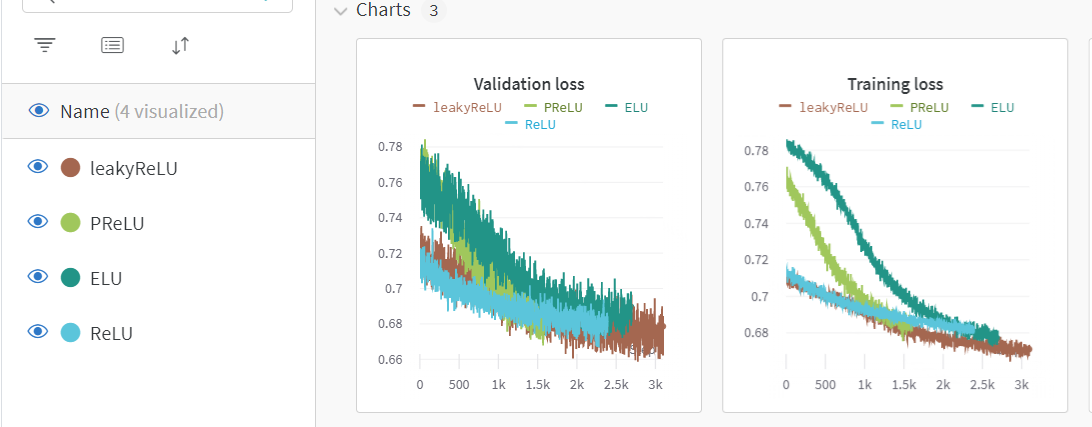

In [43]:
from IPython.display import Image
CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__")) # 현재 디렉토리 경로 가져오기
img = os.path.join(CURRENT_FILE_PATH, "activation.png") # train.csv 파일 경로
Image(img)

위 화면의 loss 그래프 wandb 링크
https://wandb.ai/loien1105/my_titanic_training?workspace=user-

# 요구사항 3. 테스트 및 submission.csv 생성

In [ ]:
    loss_value = loss_validation / num_validations  # 현재의 validation loss값
    loss_list.append(loss_value)
    if len(loss_list) > 3:
        loss_mean = sum(loss_list)/len(loss_list)
        if loss_mean < loss_value: # 현재까지 100개의 평균보다 현재의 값이 크면 count +1
            count += 1
    if epoch > 500 and count >50:   # 완만해지면 조기종료
        break
    if epoch > 100: loss_list.pop(0) # loss_list 의 요소를 100개로 유지
    if epoch >= next_print_epoch:
      print(count)
      count = 0 # 100 회 마다 count 0으로 초기화

vaildation loss 그래프는 에포크가 많아지면 점점 완만해진다. 따라서 그래프가 완만해 졌을 때, 에포크를 조기종료하고 submission을 제출해야한다. 
위 코드는 에포크를 조기종료하는 코드이다. 


In [ ]:
def test(test_data_loader):
  id = []
  survived = []
  # ... 생략
  for idx, prediction in enumerate(prediction_batch, start=892):
      print(idx, prediction.item()) # 예측된 값을 출력한다.
      id.append(idx) # 추가
      survived.append(prediction.item()) #추가
  return id, survived

test 코드를 위와 같이 고쳤다.  중간 부분은 설명하기에 큰 공간을 차지해 생략한다.
test 에서 승객id와 예측값을 리스트에 넣어 반환한다. 

In [ ]:
  # submission 파일 생성
  idx, survived = test(test_data_loader)
  data = pd.DataFrame({'PassengerId': idx, 'Survived': survived})
  data.to_csv('C:/Users/loien/Desktop/23-2/딥러닝/titanic/submission.csv', index=False)

main() 함수에서 위와 같이 submission을 출력하는 코드를 넣어준다. 

# 요구사항 4. submission.csv 제출 및 등수확인

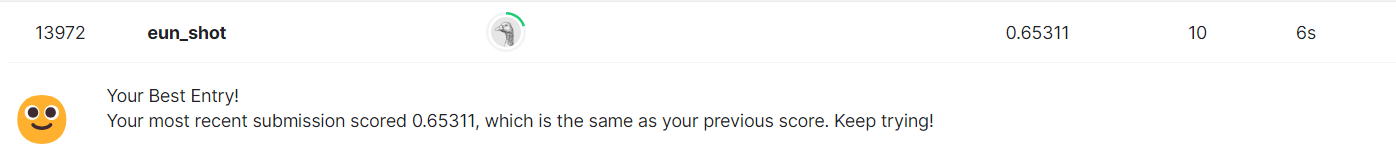

In [460]:
from IPython.display import Image
CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__")) # 현재 디렉토리 경로 가져오기
img = os.path.join(CURRENT_FILE_PATH, "keggle.png") # train.csv 파일 경로
Image(img)

# 요구사항 5. Wandb 페이지 생성 및 URL 제출

Wandb 링크(submission 파일의 wandb 링크)
https://wandb.ai/loien1105/my_model_training/runs/mr6muj39?workspace=user-loien1105
(추가)
https://wandb.ai/loien1105/my_model_training/runs/r7nhjn5x?workspace=user-

<활성화 함수별 loss 그래프>
https://wandb.ai/loien1105/my_titanic_training?workspace=user-

## 숙제 후기
score를 높이기 위해 인터넷에 여러 코드를 서치해봤다. k-fold 와 교차검증, 하이퍼파라미터와 하이퍼튜닝 등과 같은 정보들이 나왔다. 위의 방법들은 현재 숙제에서 하는 코드들과 방식이 조금 다른 것같아 도전해 보지 못했지만, 이후에 위와 같은 방법을 이용해 도전해 봐야겠다 생각했다. 

f_my_model_training_with_argparse_wandb.py 를 활용하여 훈련코드를 작성하라 하였는데, 이 파일의 코드는 회귀 문제라 타이타닉 문제와 접근 방법이 다른 것같다. 타이타닉은 생존/사망 률을 예측하는 분류 문제라고 볼 수 있는데, 회귀 문제 코드를 그대로 사용하니 스코어가 굉장히 낮게 나왔다. 특히 MSE로스함수가 적합하지 않아, 이진 분류에 적합한 BCE(이진 크로스 엔트로피) 로스 함수를 사용하였다. 

로스 함수만 바꾸면 해결 될 줄 알았으나, 로스 함수에 넣는 입력값의 텐서에 문제가 있었다. 예측값은 0일 확률과 1일 확률 총 2개의 값으로 이루어지 batch 즉,2 차원 텐서로 나오는데, 레이블은 0또는 1의 값을 가진 1차원 텐서이다. argmax로 예측값을 1차원 텐서로 바꿔서 해도 되지만 그 경우 퍼포먼스가 좋게 나오지 않아, 레이블을 2차원 텐서로 바꾸었다. 0의 값을 가지면 인덱스 0에, 1의 값을 가지면 인덱스 1의에 값을 위치 시켜, 두 차원으로 이루어진 입력을 로스함수에 넣었다. 

위까지 진행했으나, 여전히 훈련이 제대로 이루어지는 것 같지 않았다. 에포크를 500으로 줄여보기도, learning rate를 늘리고 줄여도 보았지만 모두 0인 값이나 모두 1인 값을 가지는 등 훈련이 제대로 되지 않거나, 거의 안되는 듯 했다. 이에 에포크를 2000으로 늘렸더니 loss값이 그래프상으로 줄어드는게 눈으로 보여, 훈련이 되고 있음을 알게 되었다. 
하지만 에포크를 5000으로 늘리니, 중간 부터는 loss값이 변하지 않고 오히려 과적합으로 submission score가 낮게 나왔다. 2000과 3000 사이 부터 loss 값의 그래프는 거의 유지되었다. 이를 보고, loss값이 거의 변하지 않으면 epoch를 조기 종료하여 submission을 만들도록 하였다. 